In [1]:
import matplotlib.pyplot as plt

numbers_list = [512, 1, 2, 4, 8, 16, 32]
payload_sizes = [512, 1024, 2048, 4096, 8192, 16384, 32768]

def calculate_cpi(file_path, payload_size):
    # Initialize variables to store cycle numbers
    first_cycle = None
    last_cycle = None
    instruction_count = 0

    # Track cluster entry indices
    first_cluster_index = None
    last_cluster_index = None
    
    # Track dma wait control
    dma_wait_cycle = None
    cluster_or_dispatch_cycle = None
    total_dma_to_cluster_cycles = 0

    # Track dma control
    dma_cycle = None
    dma_stop_cycle = None

    # Read the contents of the file
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Identify the first and last cluster_entry
    for i, line in enumerate(lines):
        if "cluster_entry" in line:
            if first_cluster_index is None:
                first_cluster_index = i
            last_cluster_index = i

    # Loop through each line within the range of first and last cluster_entry
    if first_cluster_index is not None and last_cluster_index is not None:
        for line in lines[first_cluster_index:last_cluster_index+1]:
            parts = line.split(':')  # Split line by colon ':'
            if len(parts) >= 2:
                cycle_str = parts[1].strip()  # Extract the cycle number string
                try:
                    cycle_number = int(cycle_str)  # Convert the string to an integer
                    if first_cycle is None:
                        first_cycle = cycle_number
                    last_cycle = cycle_number
                    instruction_count += 1

                    # Check for "pi_cl_dma_cmd_wait"
                    if "pi_cl_dma_cmd_wait" in line and dma_wait_cycle is None:
                        dma_wait_cycle = cycle_number
                    # Check for "cluster_entry" or "eu_dispatch_team_config"
                    if ("cluster_entry" in line or "eu_dispatch_team_config" in line) and dma_wait_cycle is not None:
                        cluster_or_dispatch_cycle = cycle_number
                        total_dma_to_cluster_cycles += cluster_or_dispatch_cycle - dma_wait_cycle
                        dma_wait_cycle = None  # Reset for next pair

                    # Check for "pi_cl_dma_cmd"
                    if "pi_cl_dma_cmd:" in line and dma_cycle is None:
                        #print(f"dma {cycle_number}: {line.strip()}")  # Log the line for verification
                        dma_cycle = cycle_number
                    
                    # Check for "cluster_entry" or "eu_dispatch_team_config"
                    if ("cluster_entry" in line or "eu_dispatch_team_config" in line or "pi_cl_dma_cmd_wait" in line) and dma_cycle is not None:
                        #print(f"finish dma {cycle_number}: {line.strip()}")  # Log the line for verification
                        dma_stop_cycle = cycle_number
                        total_dma_to_cluster_cycles += dma_stop_cycle - dma_cycle
                        dma_cycle = None  # Reset for next pair

                        
                except ValueError:
                    continue  # Skip lines that cannot be converted to integers

    if first_cycle is not None and last_cycle is not None:
        total_cycles = last_cycle - first_cycle
        cpi = total_cycles / instruction_count if instruction_count > 0 else 0
        ipc = instruction_count / total_cycles if total_cycles > 0 else 0
        cycles_per_byte = total_cycles / payload_size if payload_size > 0 else 0
        return total_cycles, instruction_count, cpi, ipc, cycles_per_byte, total_dma_to_cluster_cycles
    else:
        return None, None, None, None, None


In [2]:
clock_cycles_list = []
instruction_count_list = []
cpi_list = []
ipc_list = []
cycles_per_byte_list = []
total_dma_to_cluster_cycles_list = []

for i in range(1, 9):
    for payload_size, number in zip(payload_sizes, numbers_list):
        file_path = f"output_files_aes256gcm/{number}_{i}cores.txt"
        total_cycles, instruction_count, cpi, ipc, cycles_per_byte, total_dma_to_cluster_cycles = calculate_cpi(file_path, payload_size)
        if total_cycles is not None and instruction_count is not None and cpi is not None and ipc is not None and cycles_per_byte is not None:
            print(f"Results for {file_path}:")
            print("Total cycles elapsed:", total_cycles)
            print("Total instructions executed:", instruction_count)
            print("CPI:", cpi)
            print("IPC:", ipc)
            print("Cycles per byte:", cycles_per_byte)
            print("DMA control cycles:", total_dma_to_cluster_cycles)
            print()
            clock_cycles_list.append(total_cycles)
            instruction_count_list.append(instruction_count)
            cpi_list.append(cpi)
            ipc_list.append(ipc)
            cycles_per_byte_list.append(cycles_per_byte)
            total_dma_to_cluster_cycles_list.append(total_dma_to_cluster_cycles)
        else:
            print(f"Error: Cycle numbers not found in the file {file_path}.")

Results for output_files_aes256gcm/512_1cores.txt:
Total cycles elapsed: 1168701
Total instructions executed: 893806
CPI: 1.3075555545610569
IPC: 0.7647858605408911
Cycles per byte: 2282.619140625
DMA control cycles: 5424

Results for output_files_aes256gcm/1_1cores.txt:
Total cycles elapsed: 2235685
Total instructions executed: 1712422
CPI: 1.3055689543815718
IPC: 0.7659495859210935
Cycles per byte: 2183.2861328125
DMA control cycles: 10154

Results for output_files_aes256gcm/2_1cores.txt:
Total cycles elapsed: 4370371
Total instructions executed: 3349765
CPI: 1.3046798805289326
IPC: 0.7664715421185067
Cycles per byte: 2133.97021484375
DMA control cycles: 19688

Results for output_files_aes256gcm/4_1cores.txt:
Total cycles elapsed: 8636536
Total instructions executed: 6624607
CPI: 1.303705412260682
IPC: 0.7670444493023592
Cycles per byte: 2108.529296875
DMA control cycles: 37738

Results for output_files_aes256gcm/8_1cores.txt:
Total cycles elapsed: 17171917
Total instructions execute

In [3]:
# Size labels
sizes = ['512B', '1K', '2K', '4K', '8K', '16K', '32K']

# Function to plot the data
def plot_combined_data(clock_cycles, instruction_counts, cpis, ipcs, cpb, dma_cycles):
    # Plot clock cycles
    plt.figure(figsize=(10, 6))
    for core in range(8):
        start_index = core * len(sizes)
        end_index = (core + 1) * len(sizes)
        plt.plot(sizes, clock_cycles[start_index:end_index], marker='o', label=f'{core + 1} Core')
    plt.title('Clock Cycles based on Payload Size')
    plt.xlabel('Payload Size')
    plt.ylabel('Clock Cycles')
    plt.legend()
    plt.grid(True)
    plt.savefig('clock_cycles.png')
    plt.show()
    
    # Plot instruction counts
    plt.figure(figsize=(10, 6))
    for core in range(8):
        start_index = core * len(sizes)
        end_index = (core + 1) * len(sizes)
        plt.plot(sizes, instruction_counts[start_index:end_index], marker='o', label=f'{core + 1} Core')
    plt.title('Instruction Count based on Payload Size')
    plt.xlabel('Payload Size')
    plt.ylabel('Instruction Count')
    plt.legend()
    plt.grid(True)
    plt.savefig('instruction_count.png')
    plt.show()
    
    # Plot CPI
    plt.figure(figsize=(10, 6))
    for core in range(8):
        start_index = core * len(sizes)
        end_index = (core + 1) * len(sizes)
        plt.plot(sizes, cpis[start_index:end_index], marker='o', label=f'{core + 1} Core')
    plt.title('CPI based on Payload Size')
    plt.xlabel('Payload Size')
    plt.ylabel('CPI')
    plt.legend()
    plt.grid(True)
    plt.savefig('cpi.png')
    plt.show()
    
    # Plot IPC
    plt.figure(figsize=(10, 6))
    for core in range(8):
        start_index = core * len(sizes)
        end_index = (core + 1) * len(sizes)
        plt.plot(sizes, ipcs[start_index:end_index], marker='o', label=f'{core + 1} Core')
    plt.title('IPC based on Payload Size')
    plt.xlabel('Payload Size')
    plt.ylabel('IPC')
    plt.legend()
    plt.grid(True)
    plt.savefig('ipc.png')
    plt.show()

    # Plot cycles per byte
    plt.figure(figsize=(10, 6))
    for core in range(8):
        start_index = core * len(sizes)
        end_index = (core + 1) * len(sizes)
        plt.plot(sizes, cpb[start_index:end_index], marker='o', label=f'{core + 1} Core')
    plt.title('Cycles per Byte based on Payload Size')
    plt.xlabel('Payload Size (Bytes)')
    plt.ylabel('Cycles per Byte')
    plt.legend()
    plt.grid(True)
    plt.savefig('cycles_per_byte.png')
    plt.show()

    # Plot DMA cycles as a percentage of total cycles
    plt.figure(figsize=(10, 6))
    for core in range(8):
        start_index = core * len(sizes)
        end_index = (core + 1) * len(sizes)
        dma_percentages = [100 * dma / total if total > 0 else 0 for dma, total in zip(dma_cycles[start_index:end_index], clock_cycles[start_index:end_index])]
        plt.plot(sizes, dma_percentages, marker='o', label=f'{core + 1} Core')
    plt.title('DMA Cycles as a Percentage of Total Cycles')
    plt.xlabel('Payload Size')
    plt.ylabel('DMA Cycles (%)')
    plt.legend()
    plt.grid(True)
    plt.savefig('dma_cycles.png')
    plt.show()


In [4]:
# Function to plot the speedup
def plot_speedup(clock_cycles):
    single_core_cycles = clock_cycles[:len(sizes)]
    
    plt.figure(figsize=(10, 6))
    for core in range(1, 8):
        start_index = core * len(sizes)
        end_index = (core + 1) * len(sizes)
        
        multi_core_cycles = clock_cycles[start_index:end_index]
        speedup = [single_core_cycles[i] / multi_core_cycles[i] for i in range(len(sizes))]
        
        plt.plot(sizes, speedup, marker='o', label=f'{core + 1} Cores')
    
    plt.title('Speedup Compared to 1 Core')
    plt.xlabel('Payload Size')
    plt.ylabel('Speedup')
    plt.legend()
    plt.grid(True)
    plt.savefig('speedup.png')
    plt.show()

In [5]:

# Function to plot the efficiency
def plot_efficiency(clock_cycles):
    single_core_cycles = clock_cycles[:len(sizes)]
    
    plt.figure(figsize=(10, 6))
    for core in range(1, 8):
        start_index = core * len(sizes)
        end_index = (core + 1) * len(sizes)
        
        multi_core_cycles = clock_cycles[start_index:end_index]
        efficiency = [single_core_cycles[i] / (multi_core_cycles[i] * (core + 1)) for i in range(len(sizes))]
        
        plt.plot(sizes, efficiency, marker='o', label=f'{core + 1} Cores')
    
    plt.title('Efficiency Compared to 1 Core')
    plt.xlabel('Payload Size')
    plt.ylabel('Efficiency')
    plt.legend()
    plt.grid(True)
    plt.savefig('efficiency.png')
    plt.show()


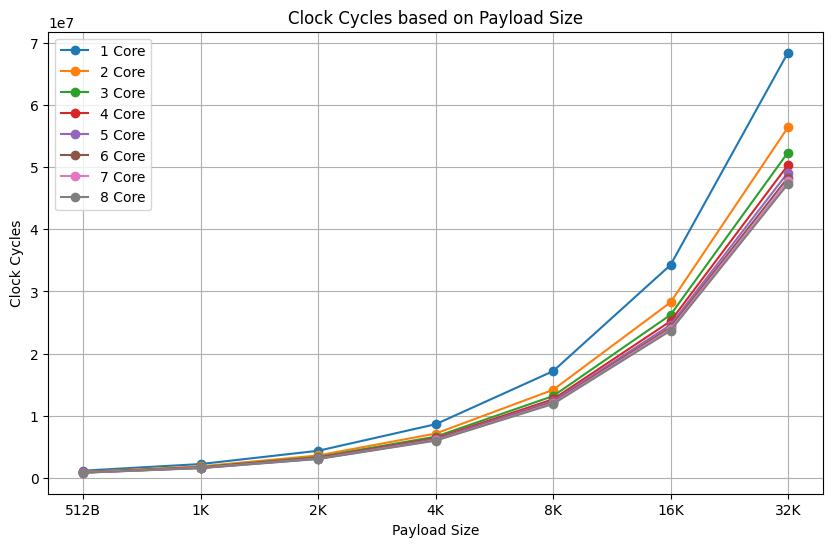

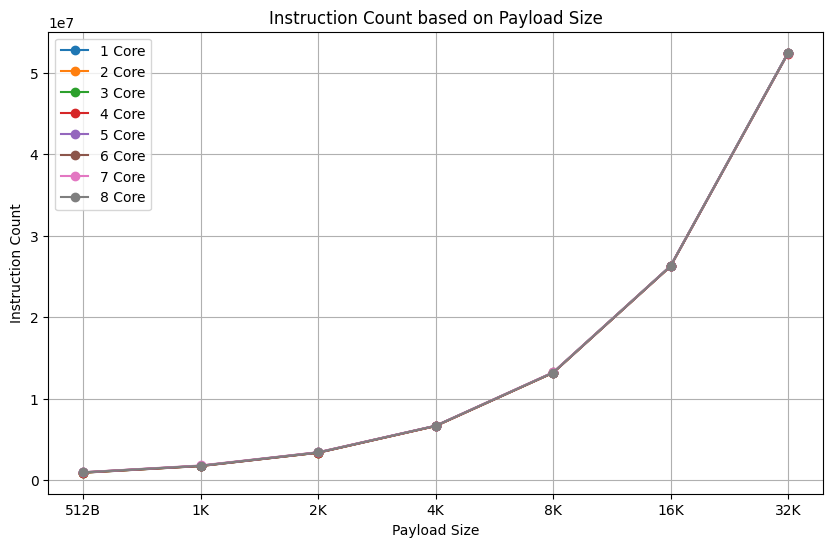

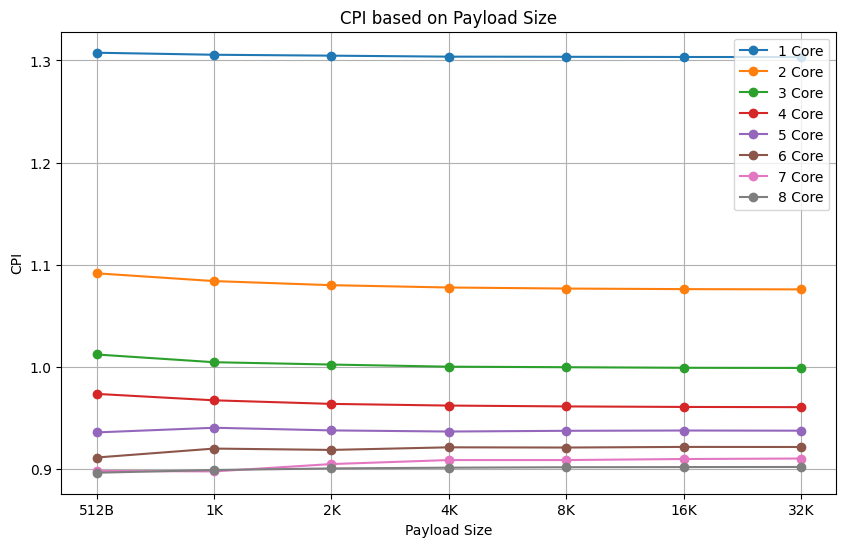

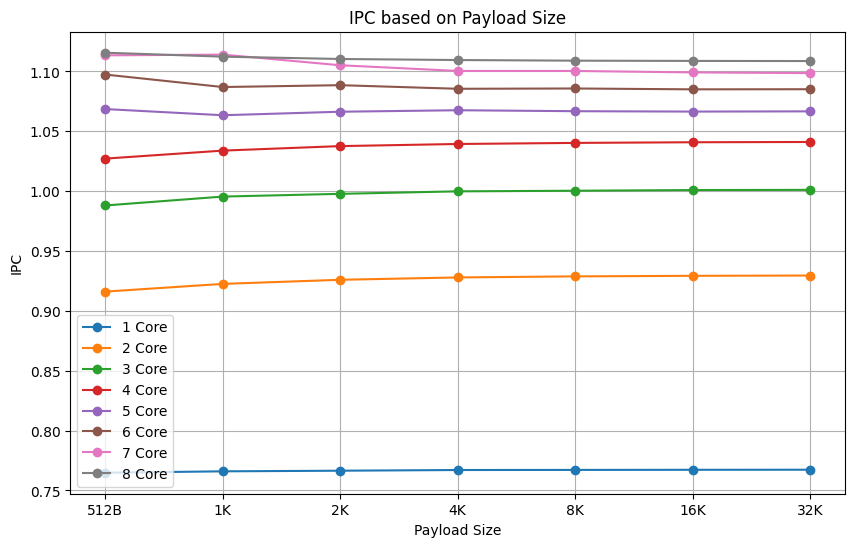

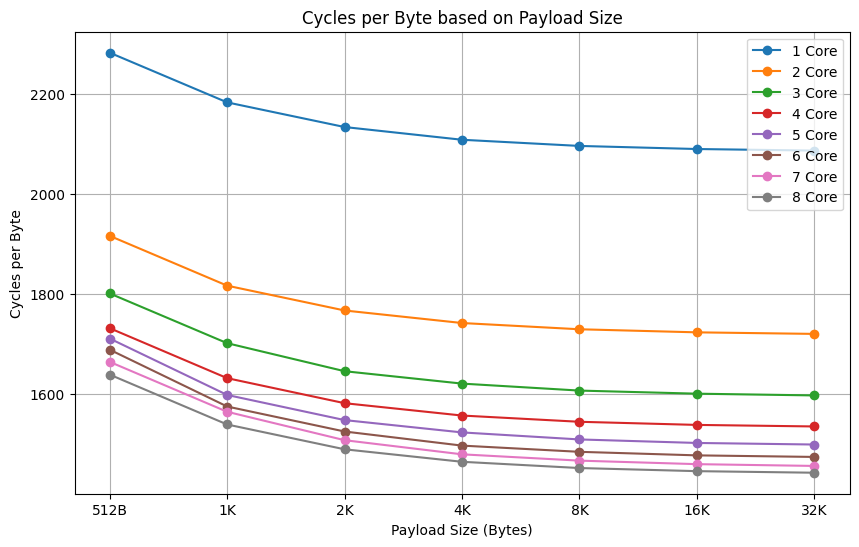

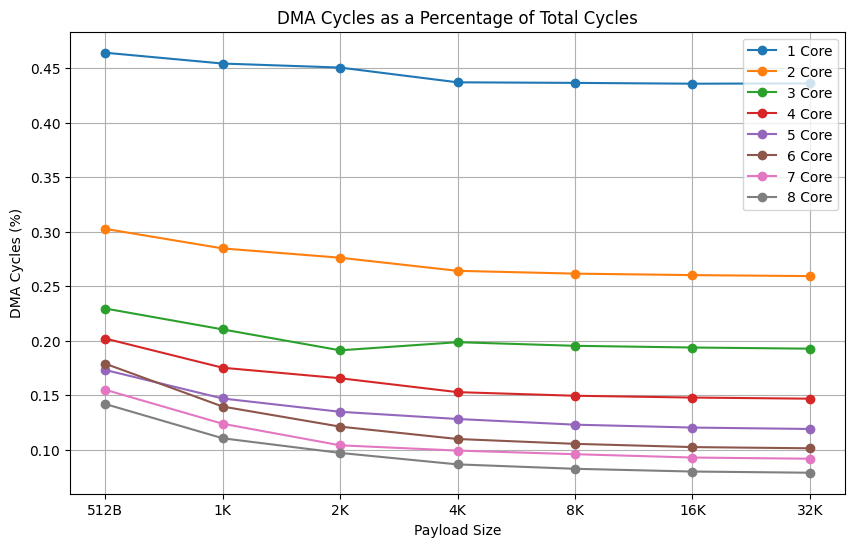

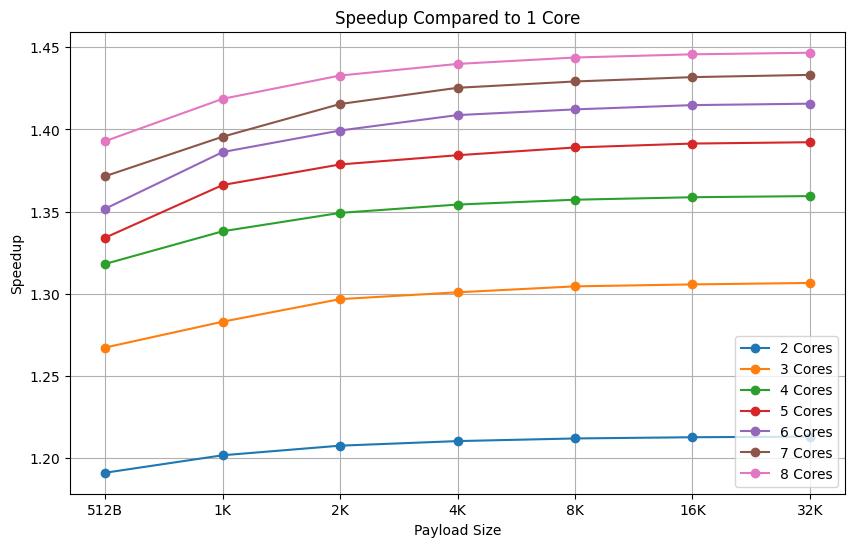

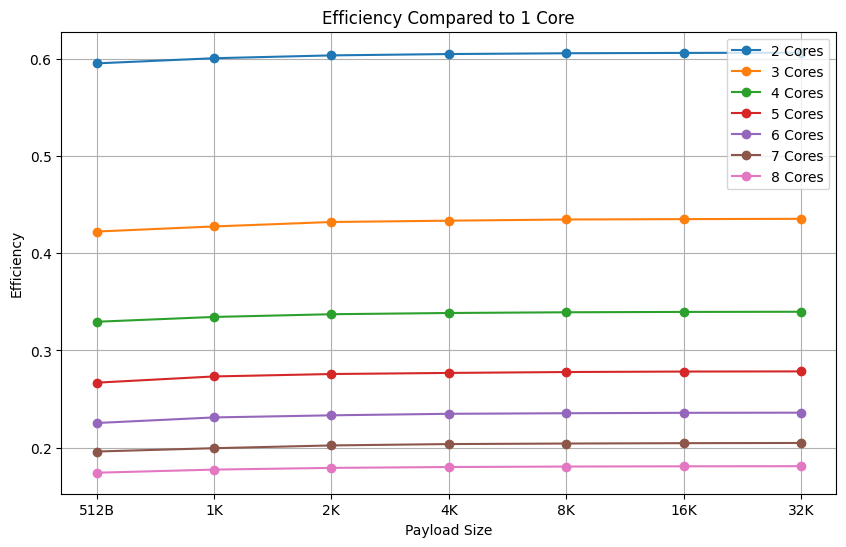

In [6]:
# Plot combined data
plot_combined_data(clock_cycles_list, instruction_count_list, cpi_list, ipc_list, cycles_per_byte_list, total_dma_to_cluster_cycles_list)
# Plot speedup
plot_speedup(clock_cycles_list)
# Plot efficiency
plot_efficiency(clock_cycles_list)